In [ ]:
# The models and experiments/explorations are done in this notebook
import pandas as pd
import numpy as np
import glob


df17 = pd.read_csv("c2017.csv")
df18 = pd.read_csv("c2018.csv")
df19 = pd.read_csv("c2019.csv")

C:\Users\samsung\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3526: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,47,48,49,50,51,52,53,54,55,56,57,58) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
def binarize_label(df, label_col='label', new_col='target'):
    df[label_col] = df[label_col].astype(str).str.lower().str.strip()
    df[new_col] = df[label_col].apply(lambda x: 0 if 'benign' in x else 1)
    return df

df17 = binarize_label(df17)
df18 = binarize_label(df18)
df19 = binarize_label(df19)

df17.drop(columns=['label'], inplace=True)
df18.drop(columns=['label'], inplace=True)
df19.drop(columns=['label'], inplace=True)


In [4]:
print(df17['target'].value_counts())
print(df18['target'].value_counts())
print(df19['target'].value_counts())

0    204828
1     86524
Name: target, dtype: int64
0    260506
1     40200
Name: target, dtype: int64
1    62681
0    18201
Name: target, dtype: int64


In [5]:
def clean_and_check(df):
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    print("Ori shape:", df.shape)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    print("total missing:", df.isnull().sum().sum())
    df.dropna(inplace=True)
    print("Cleaned shape:", df.shape)

In [6]:
clean_and_check(df17)
clean_and_check(df18)
clean_and_check(df19)

Ori shape: (291352, 59)
total missing: 424
Cleaned shape: (291140, 59)
Ori shape: (300706, 59)
total missing: 3912
Cleaned shape: (298834, 59)
Ori shape: (80882, 59)
total missing: 0
Cleaned shape: (80882, 59)


In [11]:
def show_df(df):
    labels = df.columns.tolist()
    print("labels", labels)

    row_count = len(df)
    print("rows：", row_count)

    count_benign = (df["target"] == 0).sum()
    print("benign：", count_benign)

    count_attack = (df["target"] != 0).sum()
    print("attack：", count_attack)

show_df(df17) 
show_df(df18)
show_df(df19)

labels ['ackFlagCount', 'activeMax', 'activeMean', 'activeMin', 'activeStd', 'bwdHeaderLength', 'bwdIatMax', 'bwdIatMean', 'bwdIatMin', 'bwdIatStd', 'bwdIatTotal', 'bwdPacketLengthMax', 'bwdPacketLengthMean', 'bwdPacketLengthMin', 'bwdPacketLengthStd', 'bwdPacketsS', 'bwdPshFlags', 'bwdUrgFlags', 'cweFlagCount', 'downUpRatio', 'eceFlagCount', 'finFlagCount', 'flowBytesS', 'flowDuration', 'flowIatMax', 'flowIatMean', 'flowIatMin', 'flowIatStd', 'flowPacketsS', 'fwdHeaderLength', 'fwdIatMax', 'fwdIatMean', 'fwdIatMin', 'fwdIatStd', 'fwdIatTotal', 'fwdPacketLengthMax', 'fwdPacketLengthMean', 'fwdPacketLengthMin', 'fwdPacketLengthStd', 'fwdPacketsS', 'fwdPshFlags', 'fwdUrgFlags', 'idleMax', 'idleMean', 'idleMin', 'idleStd', 'packetLengthMean', 'packetLengthStd', 'packetLengthVariance', 'pshFlagCount', 'rstFlagCount', 'subflowBwdBytes', 'subflowBwdPackets', 'subflowFwdBytes', 'subflowFwdPackets', 'synFlagCount', 'totalFwdPackets', 'urgFlagCount', 'target']
rows： 291140
benign： 204651
attack

In [22]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC



def get_model(model_type):
    if model_type == 'xgb':
        return XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)
    elif model_type == 'logreg':
        return LogisticRegression(max_iter=1000)
    elif model_type == 'nb':
        return GaussianNB()
    elif model_type == 'svm':
        return SVC(kernel='linear')
    elif model_type == 'qda':
        return QuadraticDiscriminantAnalysis()
    else:
        raise ValueError(f"Unsupported model_type: {model_type}")

def compare_generalization(df1, df2, df3, model_type='xgb'):
    model_a = get_model(model_type)
    model_b = get_model(model_type)

    common_cols = set(df1.columns) & set(df2.columns) & set(df3.columns)
    common_cols.discard('target')

    X1 = df1[list(common_cols)]
    y1 = df1['target']
    
    X2 = df2[list(common_cols)]
    y2 = df2['target']
    
    X3 = df3[list(common_cols)]
    y3 = df3['target']

    #df1 → df3
    model_a.fit(X1, y1)
    pred_a = model_a.predict(X3)
    print("Model A: trained on df1, tested on df3")
    print(classification_report(y3, pred_a, digits=3))

    #df1+df2 → df3
    X12 = pd.concat([X1, X2], ignore_index=True)
    y12 = pd.concat([y1, y2], ignore_index=True)
    
    model_b.fit(X12, y12)
    pred_b = model_b.predict(X3)
    print("Model B: trained on df1+df2, tested on df3")
    print(classification_report(y3, pred_b, digits=3))

In [23]:
compare_generalization(df17, df18, df19, model_type='nb')

Model A: trained on df1, tested on df3
              precision    recall  f1-score   support

           0      0.113     0.194     0.143     18201
           1      0.705     0.560     0.624     62681

    accuracy                          0.478     80882
   macro avg      0.409     0.377     0.384     80882
weighted avg      0.572     0.478     0.516     80882

Model B: trained on df1+df2, tested on df3
              precision    recall  f1-score   support

           0      0.087     0.116     0.099     18201
           1      0.716     0.648     0.680     62681

    accuracy                          0.528     80882
   macro avg      0.402     0.382     0.390     80882
weighted avg      0.575     0.528     0.550     80882



In [24]:
compare_generalization(df17, df18, df19, model_type='xgb')

Model A: trained on df1, tested on df3
              precision    recall  f1-score   support

           0      0.230     0.999     0.374     18201
           1      0.986     0.030     0.059     62681

    accuracy                          0.248     80882
   macro avg      0.608     0.514     0.217     80882
weighted avg      0.816     0.248     0.130     80882

Model B: trained on df1+df2, tested on df3
              precision    recall  f1-score   support

           0      0.233     0.998     0.377     18201
           1      0.988     0.044     0.084     62681

    accuracy                          0.258     80882
   macro avg      0.610     0.521     0.230     80882
weighted avg      0.818     0.258     0.150     80882



In [29]:
compare_generalization(df17, df18, df19, model_type='logreg')

c:\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model A: trained on df1, tested on df3
              precision    recall  f1-score   support

           0      0.254     0.869     0.394     18201
           1      0.873     0.260     0.401     62681

    accuracy                          0.397     80882
   macro avg      0.564     0.565     0.397     80882
weighted avg      0.734     0.397     0.399     80882



c:\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model B: trained on df1+df2, tested on df3
              precision    recall  f1-score   support

           0      0.216     0.913     0.349     18201
           1      0.594     0.037     0.069     62681

    accuracy                          0.234     80882
   macro avg      0.405     0.475     0.209     80882
weighted avg      0.509     0.234     0.132     80882



In [ ]:
compare_generalization(df17, df18, df19, model_type='qda')

c:\Python39\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Model A: trained on df1, tested on df3
              precision    recall  f1-score   support

           0      0.230     0.991     0.373     18201
           1      0.934     0.035     0.068     62681

    accuracy                          0.250     80882
   macro avg      0.582     0.513     0.220     80882
weighted avg      0.775     0.250     0.137     80882



c:\Python39\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Model B: trained on df1+df2, tested on df3
              precision    recall  f1-score   support

           0      0.140     0.533     0.222     18201
           1      0.263     0.048     0.082     62681

    accuracy                          0.157     80882
   macro avg      0.201     0.291     0.152     80882
weighted avg      0.235     0.157     0.113     80882



In [ ]:
df_17 = df17.sample(n=100, random_state=42)
df_18 = df18.sample(n=100, random_state=42)
df_19 = df19.sample(n=100, random_state=42)
compare_generalization(df_17, df_18, df_19, model_type='svm')

Model A: trained on df1, tested on df3
              precision    recall  f1-score   support

           0      0.167     1.000     0.286        12
           1      1.000     0.318     0.483        88

    accuracy                          0.400       100
   macro avg      0.583     0.659     0.384       100
weighted avg      0.900     0.400     0.459       100

Model B: trained on df1+df2, tested on df3
              precision    recall  f1-score   support

           0      0.167     0.917     0.282        12
           1      0.971     0.375     0.541        88

    accuracy                          0.440       100
   macro avg      0.569     0.646     0.412       100
weighted avg      0.874     0.440     0.510       100



In [30]:
compare_generalization(df17, df18, df17, model_type='xgb')

Model A: trained on df1, tested on df3
              precision    recall  f1-score   support

           0      1.000     0.999     0.999    204651
           1      0.997     0.999     0.998     86489

    accuracy                          0.999    291140
   macro avg      0.998     0.999     0.999    291140
weighted avg      0.999     0.999     0.999    291140

Model B: trained on df1+df2, tested on df3
              precision    recall  f1-score   support

           0      0.999     0.998     0.999    204651
           1      0.995     0.999     0.997     86489

    accuracy                          0.998    291140
   macro avg      0.997     0.998     0.998    291140
weighted avg      0.998     0.998     0.998    291140



c:\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 't-SNE on all Data')

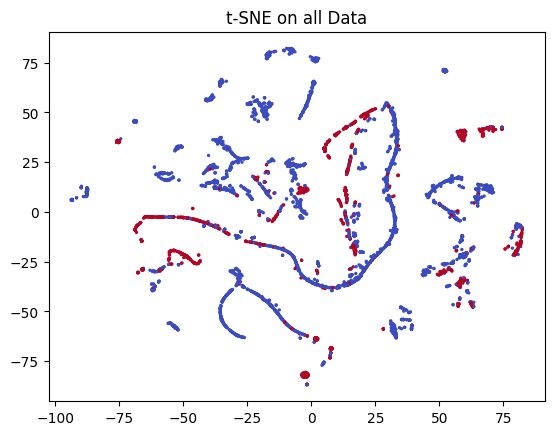

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

dfall = pd.concat([df17, df18, df19], ignore_index=True)

df_sampled = dfall.sample(n=5000, random_state=42)

X = df_sampled.drop(columns='target')
y = df_sampled['target']

X_emb = TSNE(n_components=2, perplexity=30).fit_transform(X)

plt.scatter(X_emb[:,0], X_emb[:,1], c=y, cmap='coolwarm', s=2)
plt.title("t-SNE on all Data")

c:\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 't-SNE on 2017 Data')

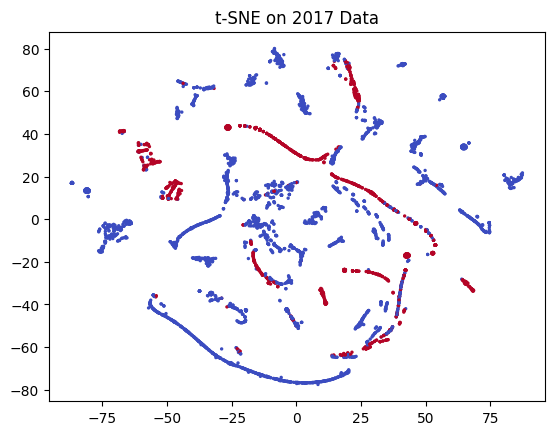

In [ ]:
df_sampled = df17.sample(n=5000, random_state=42)

X = df_sampled.drop(columns='target')
y = df_sampled['target']

X_emb = TSNE(n_components=2, perplexity=30).fit_transform(X)

plt.scatter(X_emb[:,0], X_emb[:,1], c=y, cmap='coolwarm', s=2)
plt.title("t-SNE on 2017 Data")

c:\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 't-SNE on 2019 Data')

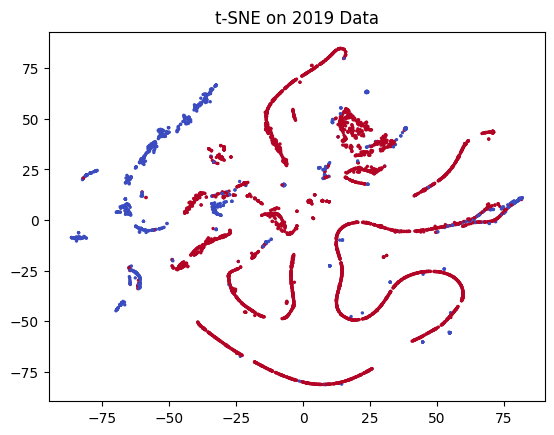

In [31]:
df_sampled = df19.sample(n=5000, random_state=42)

X = df_sampled.drop(columns='target')
y = df_sampled['target']

X_emb = TSNE(n_components=2, perplexity=30).fit_transform(X)

plt.scatter(X_emb[:,0], X_emb[:,1], c=y, cmap='coolwarm', s=2)
plt.title("t-SNE on 2019 Data")

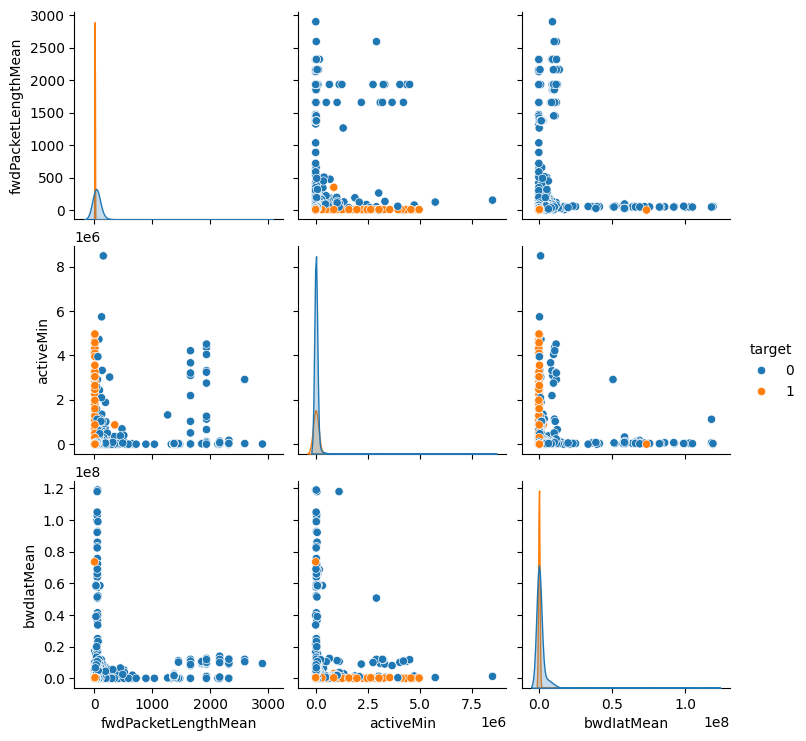

In [ ]:
import seaborn as sns

sns.pairplot(df_sampled, vars=['fwdPacketLengthMean', 'activeMin', 'bwdIatMean'], hue='target')

                 Model  Attack Recall (df1 -> df3)  \
0          Naive Bayes                       0.560   
1  Logistic Regression                       0.261   
2                  SVM                       0.318   
3              XGBoost                       0.036   
4                  QDA                       0.037   

   Attack Recall (df1+df2 -> df3)  Accuracy (df1 -> df3)  \
0                           0.648                  0.478   
1                           0.037                  0.394   
2                           0.375                  0.400   
3                           0.048                  0.252   
4                           0.048                  0.252   

   Accuracy (df1+df2 -> df3)  
0                      0.528  
1                      0.234  
2                      0.440  
3                      0.261  
4                      0.158  


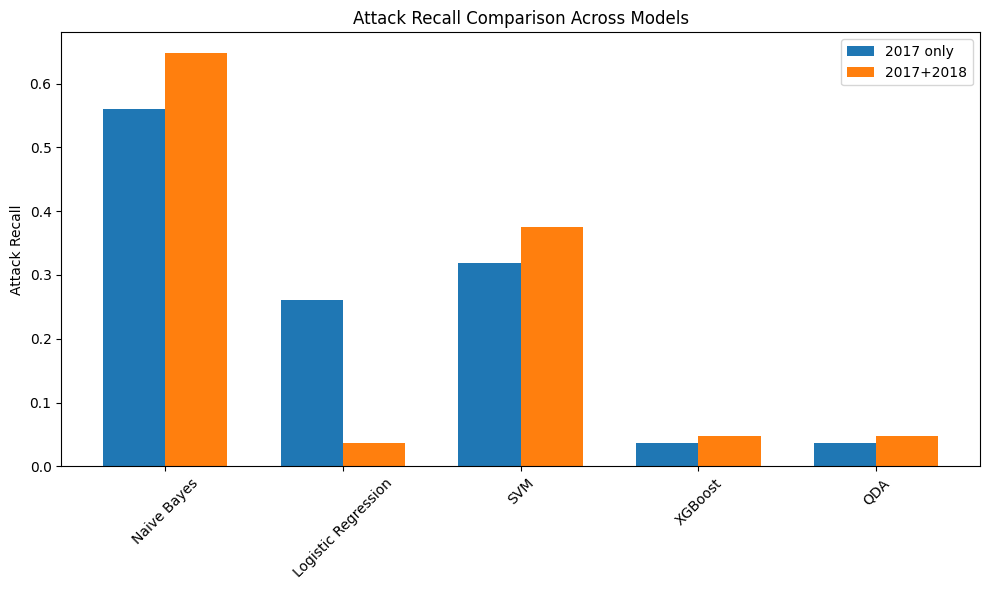

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


data = {
    'Model': ['Naive Bayes', 'Logistic Regression', 'SVM', 'XGBoost', 'QDA'],
    'Attack Recall (df1 -> df3)': [0.560, 0.261, 0.318, 0.036, 0.037],
    'Attack Recall (df1+df2 -> df3)': [0.648, 0.037, 0.375, 0.048, 0.048],
    'Accuracy (df1 -> df3)': [0.478, 0.394, 0.400, 0.252, 0.252],
    'Accuracy (df1+df2 -> df3)': [0.528, 0.234, 0.440, 0.261, 0.158],
}


df = pd.DataFrame(data)


print(df)

fig, ax = plt.subplots(figsize=(10, 6))

x = range(len(df))
bar_width = 0.35

ax.bar([i - bar_width/2 for i in x], df['Attack Recall (df1 -> df3)'], width=bar_width, label='2017 only')
ax.bar([i + bar_width/2 for i in x], df['Attack Recall (df1+df2 -> df3)'], width=bar_width, label='2017+2018')

ax.set_xticks(x)
ax.set_xticklabels(df['Model'], rotation=45)
ax.set_ylabel('Attack Recall')
ax.set_title('Attack Recall Comparison Across Models')
ax.legend()

plt.tight_layout()
plt.show()
